# More about vectors and plotting

## Vectors in Julia
You can manipulate vectors (otherwise known as lists) easily in Julia. Adding, subtracting, and dot product are built in. But cross product is not, but this is contained in the LinearAlgebra package.

In [1]:
using LinearAlgebra
using LaTeXStrings, Measures

The linear algebra package provides several functions relevant to vector mathematics:

    norm(v)   : the length of a vector v
    cross(v,w): the cross product v x w
    dot(v, w) : the dot product v • w
    
Simple examples:

In [2]:
u = [1,1,1]
v = [1,0,0]
w = [0,1,0]

println("v•w = ",dot(v,w))
println("vxw = ",cross(v,w))
println("|u| = ",round(norm(u),digits=4))

v•w = 0
vxw = [0, 0, 1]
|u| = 1.7321


## Plotting in Julia
### Electric field and potential for a finite charged stick
Let's consider a finite charged (charge=q$) line segment of length L situated on the x-axis. 
The geometry is shown below:

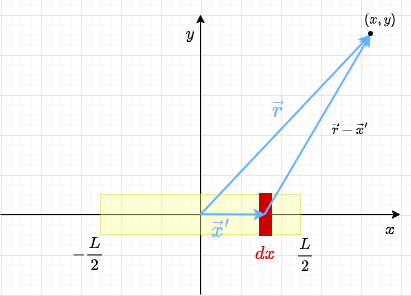

The electric field and potential can be computed using the following:
$$ dE = \frac{1}{4\pi\epsilon_0} \frac{\lambda dx}{(r-x^{\prime})^3} (\vec{r}-\vec{x}^{\prime})$$
and
$$ dE = \frac{1}{4\pi\epsilon_0} \frac{\lambda dx}{(r-x^{\prime})} $$
Note that $\lambda dx = \frac{q}{L} \frac{L}{N} = \frac{q}{N}$, and 
we can now write two functions to compute these two quantities; we'll break up the stick into N chunks and sum the effects from the first chunk (whose center is at $x_1 = -\frac{L}{2} + \frac{\Delta x}{2}$) to the Nth chunk. The $i^{th}$ chunk is at 
$$x_{i} =  -\frac{L}{2} + \frac{2i-1}{2}\Delta x,$$ 
and now we can define functions for the 
electric field and the electric potential:

In [3]:
ϵ₀ = 8.854187817e-12

function E(r, N, q=1.0e-9, L=0.10) 
    E = [0.0, 0.0] # initialize E as a 2d vector
    Δx = L/N       # step size
    for i in range(1,N)
        xᵢ = [-L/2 + 0.5*(2i-1)*Δx, 0.0] # coordinate of i-th chunck of charge
        E = E + (q/N)/(4π*ϵ₀) * (r-xᵢ)./(norm(r-xᵢ)).^3 
    end
    return E
end 

function V(r, N, q=1.0e-9, L=0.10) 
    V = 0
    Δx = L/N
    for i in range(1,N)
        xᵢ = [-L/2 + 0.5*(2i-1)*Δx, 0.0]
        V = V + (q/N)/(4π*ϵ₀)/(norm(r-xᵢ))
    end
    return V
end 

V (generic function with 3 methods)

#### Let's check these functions. 
First, a numerical check for E and V. <br>
    1. At $(x,y) = (0,1)$, the electric field must, by symmetry, be all in the y-direction.<br>
    2. At $(x,y) = (1,0)$ the electric field must be in the x-direction. (provided L<1.0)<br>
    3. At a large distance from the line charge, the potential (when $q=1e-9\,\mathrm{C}$) shoudl be 8.9 V<br>    

In [4]:
println(E([0,1], 100))
println(E([1,0], 100))
println(V([0,1], 100))

[-1.734723475976807e-18, 8.976339485502209]
[9.010074714739632, 0.0]
8.983811554490737


## Plotting the vector field
Plotting a vector field in electrostatics is tricky because the field invariably blows up in strength when 
close the the source charge(s). Since the length of the vector depends on the field strength, the plot can 
get messy and difficult to interpret. One has to play around with size of the grid used to sample the field, and the
various options in the plot. 

In the example below, I use CairoMakie to plot individual vectors on a grid surrounding the line segment. The default 
in our previous code was to have the line charge extend from $x=-0.05\,\mathrm{m}$ to $x=-0.05\,\mathrm{m}$, so I'll assume
this in setting up the plot. 

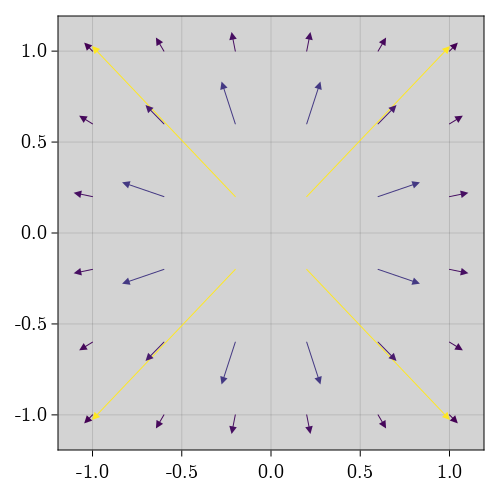

In [107]:
using CairoMakie

f = Figure(resolution = (500, 500), fontsize = 20, fonts = (;regular="CMU Serif")) # create a figure
Axis(f[1, 1], backgroundcolor = "lightgray") # create an axis on the figure

xs = LinRange(-1.0, 1.0, 6) # create a vector of x values
ys = LinRange(-1.0, 1.0, 6) # create a vector of y values
us = [E([x,y],100)[1] for x in xs, y in ys] # create an array u whose values are the x components of E
vs = [E([x,y],100)[2] for x in xs, y in ys] # create an array v whose values are the y components of E
strength = vec(sqrt.(us .^ 2 .+ vs .^ 2)) #

arrows!(xs, ys, us, vs, arrowsize = 10,  lengthscale = 0.01, arrowcolor = strength, linecolor = strength)
f # display the figure

## Contour plot of the potential
This is perhaps an easier way to visualize things. Instead of looking at the electric field, we can plot the electric potential
and since this is a *scalar* quantity, we simply compute the potential at each point on a grid, and the *contour()* function will 
plot curves of equal potential. There is also a *contourf()* function which makes a filled contour plot. Again, I use CairoMakie to make this plot.

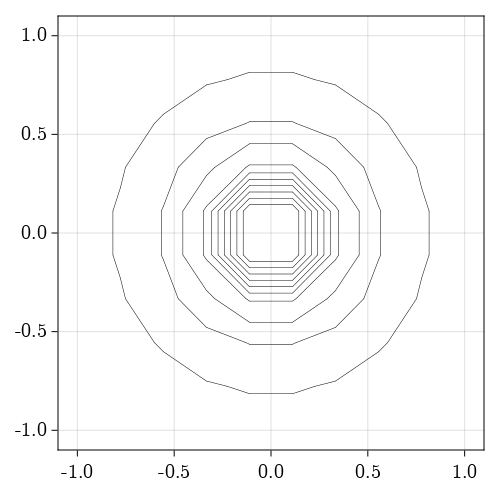

In [127]:
f = Figure(resolution = (500, 500), fontsize = 20, fonts = (;regular="CMU Serif")) # create a figure
Axis(f[1, 1]) # create an axis on the figure

xs = LinRange(-1.0, 1.0, 10) # create a vector of x values
ys = LinRange(-1.0, 1.0, 10) # create a vector of y values

z = [V([x,y],100) for x in xs, y in ys]

contour!(xs, ys, z, levels = 10, linewidth = 0.5, color = :black)

f # display the figure

## 3d Surface Plot of the Electric Potential
Another way to visualize the electric potential is to plot it as a 3D surface; in this case, the height of the surface at a point in the $(x,y)$ plane is equal to the electric potential at that point. Here, I use GLMakie to plot this surface

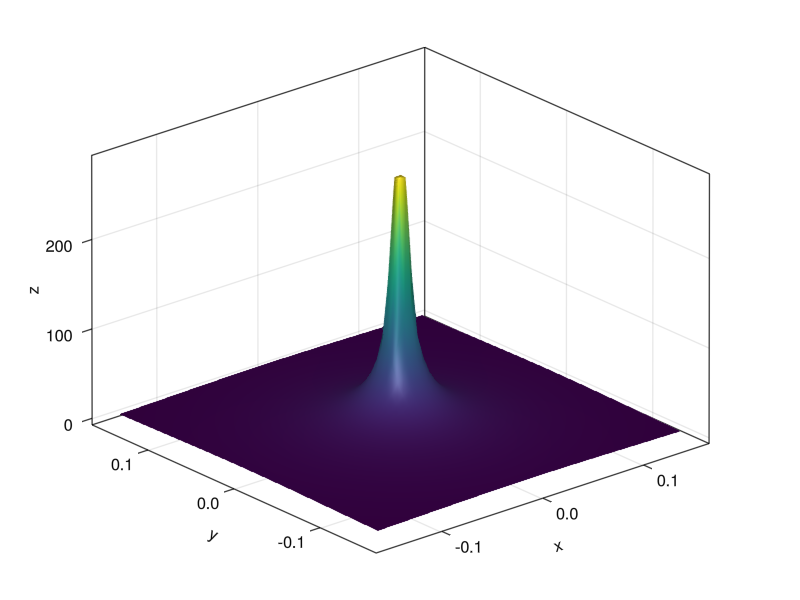

In [157]:
using GLMakie

cmap = :Spectral_11

xs = LinRange(-1.0, 1.0, 50) # create a vector of x values
ys = LinRange(-1.0, 1.0, 50) # create a vector of y values
z = [V([x,y],100) for x in xs, y in ys]

surface(x, y, z, axis=(type=Axis3,))
